# Homework 3
- Execute the below code, then answer the numbered questions.

In [1]:
import pandas as pd

df = pd.read_csv('car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [2]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [3]:
X_train.head()

,make,transmission,state,condition,odometer,auction_value
7821,kia,automatic,wi,4.4,NaN,13800.0
4127,chrysler,automatic,ca,4.3,27368.0,21300.0
12,ford,automatic,fl,2.8,66470.0,10300.0
1689,honda,automatic,NaN,3.6,25208.0,12900.0
726,hyundai,automatic,NaN,3.3,41234.0,11750.0


In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7244 entries, 7821 to 5640
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           6515 non-null   object 
 1   transmission   6486 non-null   object 
 2   state          6541 non-null   object 
 3   condition      6558 non-null   float64
 4   odometer       6541 non-null   float64
 5   auction_value  6473 non-null   float64
dtypes: float64(3), object(3)
memory usage: 396.2+ KB


In [5]:
cats = ['make', 'transmission', 'state']
nums = ['condition', 'odometer', 'auction_value']

## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipe = Pipeline([('impute', SimpleImputer(strategy='median')), ('scale', StandardScaler())])

## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline([('impute_cat', SimpleImputer(strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

In [8]:
cat_pipe.fit_transform(X_train[cats])[0, :].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [9]:
cat_pipe.fit_transform(X_train[cats])

<7244x41 sparse matrix of type '<class 'numpy.float64'>'
	with 14213 stored elements in Compressed Sparse Row format>

## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [10]:
from sklearn.compose import ColumnTransformer

processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipe, nums),
                                                      ('create_dummies', cat_pipe, cats)])

In [11]:
processing_pipeline.fit_transform(X_train).shape

(7244, 44)

## Question 5: Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [12]:
from sklearn.linear_model import LinearRegression

model_pipe = Pipeline([('feature_proc', processing_pipeline),('lm', LinearRegression())])
model_pipe = model_pipe.fit(X_train, y_train)

model_pipe.score(X_test, y_test)

0.8838274420792979

## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

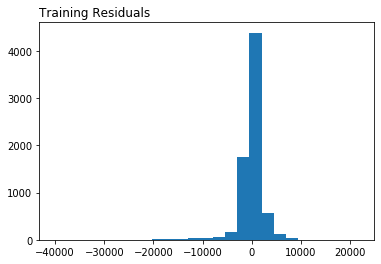

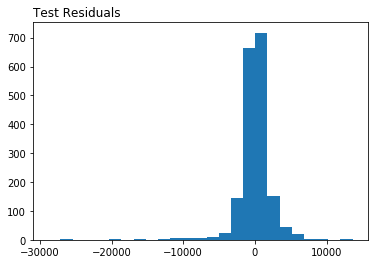

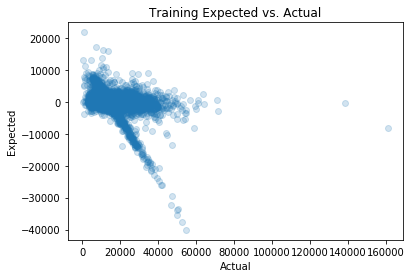

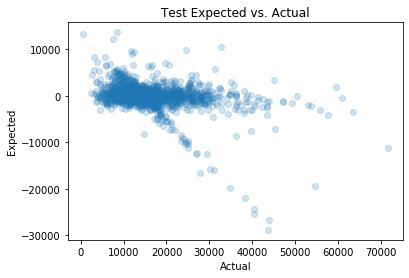

In [13]:
training_resids = model_pipe.predict(X_train) - y_train
test_resids = model_pipe.predict(X_test) - y_test

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(training_resids, bins=25)
plt.title('Training Residuals', loc='left')
plt.show()

plt.hist(test_resids, bins=25)
plt.title('Test Residuals', loc='left')
plt.show()

plt.scatter(y_train, training_resids, alpha=0.2)
plt.title('Training Expected vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.show()

plt.scatter(y_test, test_resids, alpha=0.2)
plt.title('Test Expected vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.show()

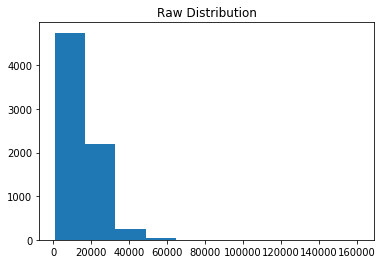

In [14]:
plt.hist(y_train)
plt.title('Raw Distribution')
plt.show()

> The distributions of the residuals are:
- Roughly symmetrically. 
- Seem to have some usually patterns in the expected vs. actual plots, as it should appear as white noise, however, it seems to have some residual correlations that the model is not capturing.

## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [15]:
from sklearn.linear_model import Ridge

model_pipe = Pipeline([('feature_proc', processing_pipeline),('lm', Ridge(alpha=100))])
model_pipe = model_pipe.fit(X_train, y_train)

model_pipe.score(X_test, y_test)

0.8824295262286378

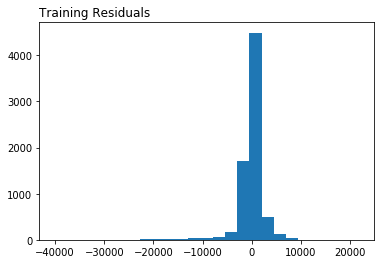

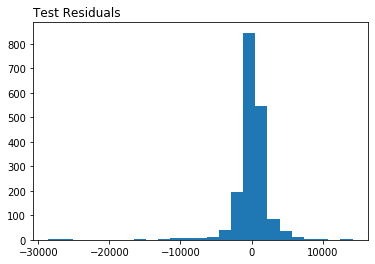

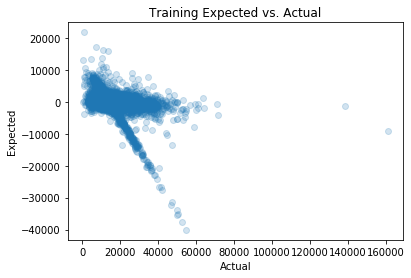

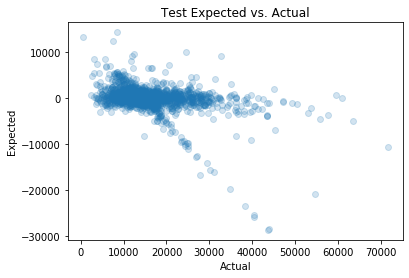

In [16]:
training_resids = model_pipe.predict(X_train) - y_train
test_resids = model_pipe.predict(X_test) - y_test

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(training_resids, bins=25)
plt.title('Training Residuals', loc='left')
plt.show()

plt.hist(test_resids, bins=25)
plt.title('Test Residuals', loc='left')
plt.show()

plt.scatter(y_train, training_resids, alpha=0.2)
plt.title('Training Expected vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.show()

plt.scatter(y_test, test_resids, alpha=0.2)
plt.title('Test Expected vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.show()